# Chronos T5 


In [1]:
import yfinance as yf


data = yf.download('BTC-USD', interval='1d')
data.to_csv('BTC-USD.csv')


[*********************100%%**********************]  1 of 1 completed


In [2]:
import pandas as pd 

data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
data.drop(['Adj Close', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)


In [3]:
import ta

data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

#Precio Futuro
data['Close_future'] = data['Close'].shift(-1)
# Dirección del Movimiento de Precio
data['Price_Up'] = (data['Close_future'] > data['Close']).astype(int)


#Boramos datos nulos
data.dropna(inplace=True)

data.to_csv('BTC-Indicators.csv',index=['Date'])
data = pd.read_csv('BTC-Indicators.csv', parse_dates=['Date'], index_col=['Date'])



In [4]:
features = ['Close', 'sma', 'ema20', 'ema50', 'ema200', 'rsi', 'macd', 'macd_signal']
target = ['Price_Up']
# Separar X e y
X = data[features]
y = data[target]



In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle= False)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Train Chronos T5 


In [31]:
import torch
from chronos import ChronosPipeline
print('cuda' if torch.cuda.is_available() else 'cpu')
pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-small',
    device_map='cuda',
    torch_dtype= torch.float32
)

context = torch.tensor(X_train['Close'], dtype=torch.float32)
prediction_length = 31

forecast = pipeline.predict(context, prediction_length)
forecast

cuda


C:\Users\ivoto\AppData\Local\Temp\ipykernel_11732\134942701.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(X_train['Close'], dtype=torch.float32)


tensor([[[67854.4609, 67854.4609, 66788.6641, 67854.4609, 68564.9844,
          67143.9453, 67143.9453, 66078.1484, 66788.6641, 66433.4297,
          66433.4297, 66078.1484, 67143.9453, 66788.6641, 66788.6641,
          65367.6289, 67499.1797, 66788.6641, 65012.3945, 64657.1133,
          64657.1133, 65367.6289, 65367.6289, 64657.1133, 66788.6641,
          69275.5000, 67854.4609, 69630.7344, 67854.4609, 69986.0156,
          69275.5000],
         [66788.6641, 67499.1797, 67499.1797, 68920.2188, 68564.9844,
          68564.9844, 68209.6953, 67854.4609, 67499.1797, 67499.1797,
          68564.9844, 68920.2188, 68920.2188, 68564.9844, 69275.5000,
          68920.2188, 68920.2188, 67854.4609, 69275.5000, 69630.7344,
          69275.5000, 69630.7344, 68920.2188, 69275.5000, 68564.9844,
          68564.9844, 68564.9844, 68564.9844, 68920.2188, 69275.5000,
          68920.2188],
         [65722.9141, 65012.3945, 64301.8789, 65367.6289, 64657.1133,
          64657.1133, 64657.1133, 65367.6289

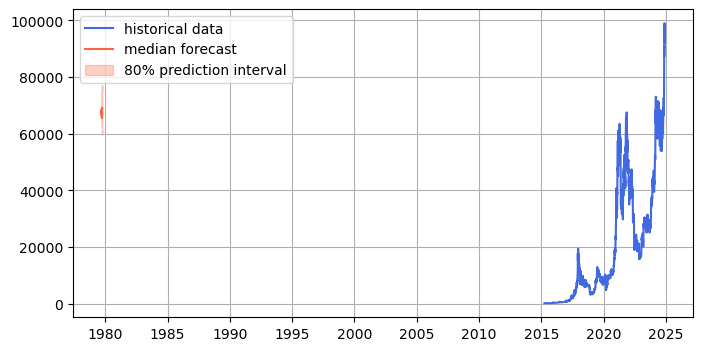

In [32]:
import numpy as np
import matplotlib.pyplot as plt
# visualize the forecast
forecast_index = range(len(data), len(data) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(data["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()